# Introduction to Machine Learning with Alerts

The objective of this hands-on activity is to create and evaluate a Real-Bogus classifier using ZTF alert data.  You will be provided with a curated set of data which has already been labeled via the marshalls and the zooniverse website.  In this exercise, you will:

1. Load data
2. Examine and select features
3. Curate a test and training set
4. Train a machine learned classifier
5. Compare the performance of different learning algorithms
6. [ optional ] experiment with alternate feature selections and compare performance
7. [ optional ] label additional examples and incorporate into training set

#### What's Not Covered

There are many topics to cover, and due to time constraints, we cannot cover them all.  Omitted is a discussion of [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) and [hyperparameter tuning](http://scikit-learn.org/stable/modules/grid_search.html).  I encourage you to click through and read those articles by sklearn.

## 1. Load Data

Visit the [ZTFSS github repo](https://github.com/ZwickyTransientFacility/ztfss18/tree/master/data) to retrieve the file labeled *labeled.npy*.  This file contains data that has been labeled either 0 (BOGUS) or 1 (REAL).  The final column in the npy file contains label.

The columns of the *labeled.npy* are:

[ magpsf, sigmapsf, chipsf, magap, sigmagap, magapbig, sigmagapbig, sky, magdiff, fwhm, classtar, mindtoedge, magfromlim, seeratio, aimage, bimage, aimagerat, bimagerat, elong, nneg, nbad, sumrat, distnr, magnr, sigmagnr, chinr, sharpnr, ranr, decnr, ssdistnr, ssmagnr, scorr, scimaglim, refmaglim, zpmaginpsci, zpmaginpsciunc, zpdiff, zpref, fluxrat, scigain, scisat, scibckgnd, scisigpix, sciinpseeing, refsat, refbckgnd, refsigpix, refinpseeing, pdiffbckgnd, ndiffbckgnd, diffsigpix, diffnbadpixbef, diffnbadpixaft, diffpctbad, diffmaglim, difffwhm, difnumnoisepix, diffavgsqbef, diffavgsqaft, diffavgsqchg, diffavgchisqaft, infobitssci, infobitsref, ncandscimrefraw, ncandscimreffilt, ncandrefmsciraw, ncandrefmscifilt, status] 



In [1]:
import numpy as np
dat = np.load('../data/ml-alerts/labeled.npy')

COL_NAMES = ["magpsf", "sigmapsf", "chipsf", "magap", "sigmagap", "magapbig", "sigmagapbig", "sky", 
            "magdiff", "fwhm", "classtar", "mindtoedge", "magfromlim", "seeratio", "aimage", "bimage", 
            "aimagerat", "bimagerat", "elong", "nneg", "nbad", "sumrat", "distnr", "magnr", "sigmagnr", 
            "chinr", "sharpnr", "ranr", "decnr", "ssdistnr", "ssmagnr", "scorr", "scimaglim", "refmaglim", 
            "zpmaginpsci", "zpmaginpsciunc", "zpdiff", "zpref", "fluxrat", "scigain", "scisat", "scibckgnd", 
            "scisigpix", "sciinpseeing", "refsat", "refbckgnd", "refsigpix", "refinpseeing", "pdiffbckgnd", 
            "ndiffbckgnd", "diffsigpix", "diffnbadpixbef", "diffnbadpixaft", "diffpctbad", "diffmaglim", 
            "difffwhm", "difnumnoisepix", "diffavgsqbef", "diffavgsqaft", "diffavgsqchg", "diffavgchisqaft", 
            "infobitssci", "infobitsref", "ncandscimrefraw", "ncandscimreffilt", "ncandrefmsciraw", 
            "ncandrefmscifilt", "status"]
             
# INSTRUCTION: Verify that the shape of the data is the number of COL_NAMES + 1
#
print(dat.shape)
print(len(COL_NAMES))
if dat.shape[1] != (len(COL_NAMES) + 1):
    print("ERROR!  Number of columns in labeled.npy != len(COL_NAMES) + 1")
    
    
# INSTRUCTION: How many real and bogus examples are in this labeled set
#
real_mask = dat[:,-1] == 1
bogus_mask = ~real_mask
print("Number of Real Examples: {}".format(np.sum(real_mask)))
print("Number of Bogus Examples: {}".format(np.sum(bogus_mask)))

(17321, 69)
68
Number of Real Examples: 6146
Number of Bogus Examples: 11175


## 2. Select Features

While it may be tempting to use all features provided, some of the features may not be relevant to the concept of discriminating between real and bogus sources. 

The columns of the *labeled.npy* are:

[ magpsf, sigmapsf, chipsf, magap, sigmagap, magapbig, sigmagapbig, sky, magdiff, fwhm, classtar, mindtoedge, magfromlim, seeratio, aimage, bimage, aimagerat, bimagerat, elong, nneg, nbad, sumrat, distnr, magnr, sigmagnr, chinr, sharpnr, ranr, decnr, ssdistnr, ssmagnr, scorr, scimaglim, refmaglim, zpmaginpsci, zpmaginpsciunc, zpdiff, zpref, fluxrat, scigain, scisat, scibckgnd, scisigpix, sciinpseeing, refsat, refbckgnd, refsigpix, refinpseeing, pdiffbckgnd, ndiffbckgnd, diffsigpix, diffnbadpixbef, diffnbadpixaft, diffpctbad, diffmaglim, difffwhm, difnumnoisepix, diffavgsqbef, diffavgsqaft, diffavgsqchg, diffavgchisqaft, infobitssci, infobitsref, ncandscimrefraw, ncandscimreffilt, ncandrefmsciraw, ncandrefmscifilt, status] 

Any feature related to the zero-point is not relevant (e.g.,  starts with zp*).  Similarly, classstar is a star-galaxy separation score that is considered unreliable. We've removed it.  The following are the list of features we have preserved.

In [2]:
featnames = ['aimage', 'aimagerat', 'bimage', 'bimagerat', 'chinr', 'chipsf', 
             'distnr', 'elong', 'fwhm', 'magap', 'magapbig', 'magdiff', 'magfromlim', 
             'magnr', 'magpsf', 'mindtoedge', 'nbad', 'nneg', 'seeratio', 'sharpnr', 
             'sigmagap', 'sigmagapbig', 'sigmagnr', 'sigmapsf', 'sky', 'ssdistnr', 
             'ssmagnr', 'sumrat', 'diffavgchisqaft', 'diffavgsqaft', 'diffavgsqbef', 
             'diffavgsqchg', 'difffwhm', 'diffmaglim', 'diffnbadpixaft', 'diffnbadpixbef',
             'diffpctbad', 'diffsigpix', 'difnumnoisepix', 'fluxrat', 'ncandrefmscifilt',
             'ncandrefmsciraw', 'ncandscimreffilt', 'ncandscimrefraw', 'ndiffbckgnd',
             'pdiffbckgnd', 'refbckgnd', 'refinpseeing', 'refmaglim', 'refsat', 'refsigpix',
             'scibckgnd', 'scigain', 'sciinpseeing', 'scimaglim', 'scisat', 'scisigpix', 'status', 'scorr']

#INSTRUCTION: filter the columns from 'dat' to just contain the features in 'feats', in the order that appears above.
#
col_permutation = []
for name in featnames:
    col_permutation.append(COL_NAMES.index(name))
col_permutation.append(len(COL_NAMES)) # grab the label column!

print("Permutations: {}".format(col_permutation))

feats_plus_label = dat[:,col_permutation]

print("dat.shape={}".format(dat.shape))
print("feats_plus_label.shape={}".format(feats_plus_label.shape))




Permutations: [14, 16, 15, 17, 25, 2, 22, 18, 9, 3, 5, 8, 12, 23, 0, 11, 20, 19, 13, 26, 4, 6, 24, 1, 7, 29, 30, 21, 60, 58, 57, 59, 55, 54, 52, 51, 53, 50, 56, 38, 66, 65, 64, 63, 49, 48, 45, 47, 33, 44, 46, 41, 39, 43, 32, 40, 42, 67, 31, 68]
dat.shape=(17321, 69)
feats_plus_label.shape=(17321, 60)


## 3. Curate a Test and Training Set

We need to reserve some of our labeled data for evaluation.  This means we must split up the labeled data we have into the set used for training (training set), and the set used for evaluation (test set).  Ideally, the distribution of real and bogus examples in both the training and test sets are roughly identical.  One can use [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and use the stratify option.  

For ZTF data, we split the training and test data by date.  That way repeat observations from the same night (which might be nearly identical) cannot be split into the training and test set, and artificially inflate test performance.  Also, due to the change in survey objectives, it's possible that the test set features have drifted away from the training sets.

Provided is *nid.npy* which contains the Night IDs for ZTF.  Split on nid=500 (May 16, 2018).  This should leave you with roughly 500 reals in your test set.


In [3]:
nids = np.load('../data/ml-alerts/nid.npy')

# INSTRUCTION: nid.npy contains the nids for this labeled data.
# Split the data into separate data structures for train/test data at nid=500.
# Verify that you have at least 500 reals in your test set.

nid_mask_train = nids <= 500
nid_mask_test = ~nid_mask_train

train_plus_label = feats_plus_label[nid_mask_train,:]
test_plus_label = feats_plus_label[nid_mask_test,:]

nreals_train = np.sum(train_plus_label[:,-1] == 1)
nbogus_train = np.sum(train_plus_label[:,-1] == 0)
nreals_test = np.sum(test_plus_label[:,-1] == 1)
nbogus_test = np.sum(test_plus_label[:,-1] == 0)


print("TRAIN Num Real={}, Bogus={}".format(nreals_train, nbogus_train))    
print("TEST Num Real={}, Bogus={}".format(nreals_test, nbogus_test)) 

TRAIN Num Real=5589, Bogus=10207
TEST Num Real=557, Bogus=968


## 4. Train a Classifier

#### Part 1: Separate Labels from the Features

Now store the labels separately from the features.  

#### Part 2: Handle Missing Values

Almost ready for training.  However, sklearn will throw an error if there are NaN's in the features.  And there are some features (that end with 'nr') that have lots of NaN's.  We will need to replace the \*nr features with a sentinel value (-999).  Any other features containing NaNs should be subject to median interpolation. Use the [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) module from sklearn.  Make this imputation a subroutine, as you'll need to call it separately for the train and test data.  (Why?)

Once the imputation is done, we can choose multiple classifiers to train.

In [4]:
# INSTRUCTION: Separate the labels from the features

train_feats = train_plus_label[:,:-1]
train_labels = train_plus_label[:,-1]

test_feats = test_plus_label[:,:-1]
test_labels = test_plus_label[:,-1]

In [5]:
# INSTRUCTION: Write a small routine for doing the imputation described above.
# 1) Find any feature ending with 'nr' and substitute NaNs with -999
# 2) For all other features, substitute NaNs with the median value of that feature
# 3) Verify NaNs are gone

from sklearn.preprocessing import Imputer

def impute_missing(feats, featnames):

    # impute -999 into *nr features
    nr_feats_colidx = []
    nr_featnames = []
    for fname in featnames:
        if fname.endswith('nr'):
            nr_featnames.append(fname)
            nr_feats_colidx.append(featnames.index(fname))

    for i in range(len(nr_feats_colidx)):
        colidx = nr_feats_colidx[i]
        colname = nr_featnames[i]
        nan_mask = np.isnan(feats[:,colidx])
        print("Substituting {} nans for -999 in {}".format(np.sum(nan_mask), colname))
        feats[nan_mask,colidx] = -999

    # impute other missing values with median feature value
    imp = Imputer(missing_values='NaN', strategy='median', axis=0) 
    imp.fit(feats) 
    feats = imp.transform(feats)
    print("Imputed NaNs")
    return feats

train_feats = impute_missing(train_feats, featnames)
test_feats = impute_missing(test_feats, featnames)


Substituting 0 nans for -999 in chinr
Substituting 0 nans for -999 in distnr
Substituting 0 nans for -999 in magnr
Substituting 0 nans for -999 in sharpnr
Substituting 0 nans for -999 in sigmagnr
Substituting 13487 nans for -999 in ssdistnr
Substituting 13487 nans for -999 in ssmagnr
Imputed NaNs
Substituting 0 nans for -999 in chinr
Substituting 0 nans for -999 in distnr
Substituting 0 nans for -999 in magnr
Substituting 0 nans for -999 in sharpnr
Substituting 0 nans for -999 in sigmagnr
Substituting 1520 nans for -999 in ssdistnr
Substituting 1520 nans for -999 in ssmagnr
Imputed NaNs


#### Part 2. Scaling Data

With missing values handled, you're closing to training your classifiers.  However, because distance metrics can be sensitive to the scale of your data (e.g., some features span large numeric ranges, but others don't), it is important to normalize data within a standard range such as (0, 1) or with z-score normalization (scaling to unit mean and variance).  Fortunately, sklearn also makes this quite easy.  Please review sklearn's [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module options, specifically StandardScaler which corresponds to z-score normalization and MinMaxScaler.  Please implement one.  

FYI - Neural networks and Support Vector Machines (SVM) are sensitive to the scale of the data.  Decision trees (and therefore Random Forests) are not. 

In [6]:
# INSTRUCTION: Re-scale your data using either the MinMaxScaler or StandardScaler from sklearn
#
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train_feats)
train_feats = scaler.transform(train_feats)

scaler = MinMaxScaler().fit(test_feats)
test_feats = scaler.transform(test_feats)

#### Part 3. Train Classifiers

Import a few classifiers and build models on your training data.  Some suggestions include a [Support Vector Machine](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), [Neural Net](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier), [NaiveBayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) and [K-Nearest Neighbor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).  

All of these classifiers have parameters which should be tuned on an set of data that's independent of both the train and test data.  This tutorial does not cover parameter tuning, but a good review of how to tune classifiers is covered [here](http://scikit-learn.org/stable/modules/grid_search.html).

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

knn3 = KNeighborsClassifier(3),
svml = SVC(kernel="linear", C=0.025, probability=True)
svmr = SVC(gamma=2, C=1, probability=True)
dtre = DecisionTreeClassifier(max_depth=5)
rafo = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1)
nnet = MLPClassifier(alpha=1)
naiv = GaussianNB()

# INSTRUCTION: Train three classifiers and run on your test data. Here's an example to get your started.  
# Which ones seems to take longer to train?
# 

rafo.fit(train_feats, train_labels)
rafo_scores = rafo.predict_proba(test_feats)[:,1]

dtre.fit(train_feats, train_labels)
dtre_scores = dtre.predict_proba(test_feats)[:,1]

svmr.fit(train_feats, train_labels)
svmr_scores = svmr.predict_proba(test_feats)[:,1]


#### Part 4. Plot Results

In order to assess performance, we plot a histogram of the test set RB scores, comparing the distributions of the labeled reals vs. boguses.  The scores of the reals should be close to 1, while the scores of the boguses should be closer to 0.  The more separated the distribution of scores, the better performing your classifier is.

Compare the score distributions of the classifiers you've trained.  Trying displaying as a cumulative distribution and as a straight histogram.  

*Optional:* What would the decision thresholds be at the  5, 10 and 20% false negative rate (FNR)?  What would the decision threshold be at the 1, 10, and 20% false positive rate?

nreal=557, nbogus=968
05% FNR Detection threshold=1.00
10% FNR Detection threshold=1.00
20% FNR Detection threshold=1.00
1% FPR Detection threshold=1.00
10% FPR Detection threshold=1.00
20% FPR Detection threshold=1.00


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


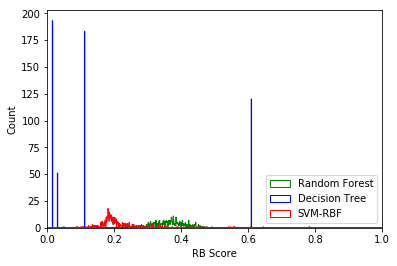

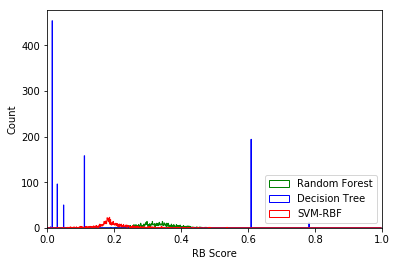

In [8]:
# INSTRUCTION: create masks for the real and bogus examples of the test set
%matplotlib inline
import matplotlib.pyplot as plt

real_mask = test_labels == 1
bogus_mask = test_labels == 0
print('nreal={}, nbogus={}'.format(np.sum(real_mask), np.sum(bogus_mask)))

# INSTRUCTION: First compare the classifiers' scores on the test reals only
#

scores_list = [rafo_scores, dtre_scores, svmr_scores]
legends = ['Random Forest', 'Decision Tree', 'SVM-RBF'] 
colors = ['g', 'b', 'r'] 


# Comparison on Reals
#
plt.figure()
ax = plt.subplot(111)
rbbins = np.arange(0,1,0.001)
for i, scores in enumerate(scores_list):
    vals, bins, dummy = ax.hist(scores[real_mask], rbbins, histtype='step', cumulative=False, normed=False, color=colors[i])
#     vals, bins, dummy = ax.hist(scores[real_mask], rbbins, histtype='step', cumulative=True, normed=True, color=colors[i])
ax.set_xlabel('RB Score')
ax.set_ylabel('Count')
ax.set_xbound(0, 1)
ax.legend(legends, loc=4)

# Calculating Thresholds
#
bins = bins[:-1]
vals_mask_05 = vals < 0.05
vals_mask_10 = vals < 0.10
vals_mask_20 = vals < 0.20
thres_05 = (bins[vals_mask_05])[-1]
thres_10 = (bins[vals_mask_10])[-1]
thres_20 = (bins[vals_mask_20])[-1]
print("05% FNR Detection threshold={:.2f}".format(thres_05))
print("10% FNR Detection threshold={:.2f}".format(thres_10))
print("20% FNR Detection threshold={:.2f}".format(thres_20))

# Comparison on Reals
#
plt.figure()
ax = plt.subplot(111)
rbbins = np.arange(0,1,0.001)
for i, scores in enumerate(scores_list):
    vals, bins, dummy = ax.hist(scores[bogus_mask], rbbins, histtype='step', cumulative=False, normed=False, color=colors[i])
#     vals, bins, dummy = ax.hist(scores[bogus_mask], rbbins, histtype='step', cumulative=True, normed=True, color=colors[i])

ax.set_xlabel('RB Score')
ax.set_ylabel('Count')
ax.set_xbound(0, 1)
ax.legend(legends, loc=4)

bins = bins[:-1]
vals_mask_99 = vals < 0.99
vals_mask_90 = vals < 0.90
vals_mask_80 = vals < 0.80
thres_99 = (bins[vals_mask_99])[-1]
thres_90 = (bins[vals_mask_90])[-1]
thres_80 = (bins[vals_mask_80])[-1]
print("1% FPR Detection threshold={:.2f}".format(thres_99))
print("10% FPR Detection threshold={:.2f}".format(thres_90))
print("20% FPR Detection threshold={:.2f}".format(thres_80))